In [2]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4
from typhon import plots
import xarray as xr

import konrad

plots.styles.use('typhon')

In [3]:
cp_air = 1000 #J kg-1 K-1
g = 10 #m s-2
Ra = 287 #J kg-1 K-1 air
Rv = 461 #J kg-1 K-1 water vapor
Lv = 2.3E6 #J kg-1
eps = Ra/Rv #dimensionless
p_rad = 1E5 #Pa, reference pressure for absorption cross sections
e_sat_ref = 610.94 #Pa, saturation water vapor pressure for Tref = 273.15 K
T_ref = 273.15 #K

lapse_dry = -g/cp_air #K/m

In [4]:
def manabe_rh(rhs, p):
    rh = np.maximum(0,rhs*(p/p[0]-0.02)/(1-0.02))
    return rh

def fixed_rh(rhs,p):
    rh = np.ones_like(p)*rhs
    return rh

def w_sat_p(T): #Pa
    e_sat = e_sat_ref * np.exp(-Lv/Rv*(1/T-1/T_ref))
    return e_sat

def mmr_sat(T,p): #kg/kg
    r_sat = eps*w_sat_p(T)/p
    return r_sat

def vmr_sat(T,p): #m3/m3
    r_sat = w_sat_p(T)/p
    return r_sat
    
def rh_to_mmr(rh,T,p):
    mixing_saturation = mmr_sat(T,p)
    mixing_ratio = np.maximum(5e-6,rh*mixing_saturation)
    
    return mixing_ratio

def rh_to_vmr(rh,T,p):
    mixing_saturation = vmr_sat(T,p)
#    mixing_ratio = np.maximum(5e-9,rh*mixing_saturation)
    mixing_ratio = np.maximum(5e-6,konrad.physics.relative_humidity2vmr(RH,p,T))
#    mixing_ratio = konrad.physics.relative_humidity2vmr(RH,p,T)
    
    return mixing_ratio

def vmr_to_rh(vmr,T,p):
    mixing_saturation = vmr_sat(T,p)
    relative_humidity = vmr/mixing_saturation
    relative_humidity = konrad.physics.vmr2relative_humidity(vmr,p,T)
    
    return relative_humidity

def vmr_to_mmr(vmr):
    mass_mix = vmr*eps
    
    return mass_mix

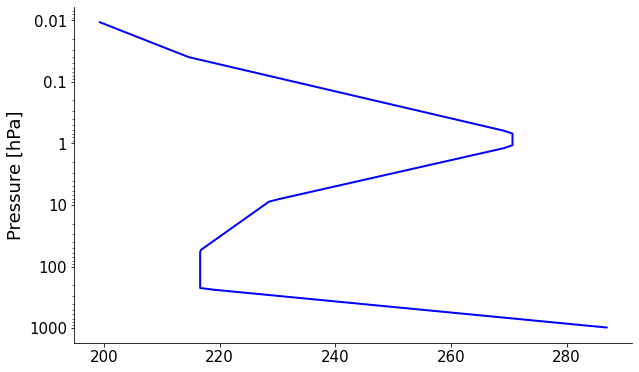

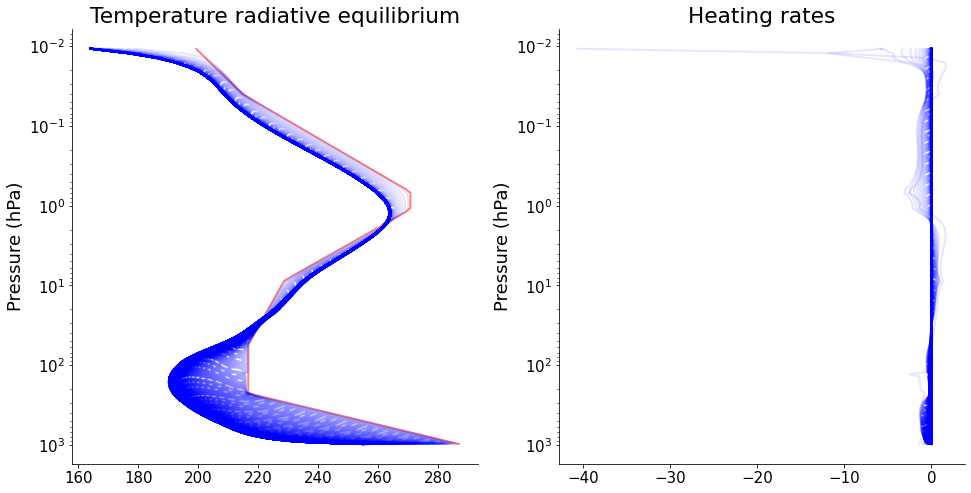

[288.30652702]


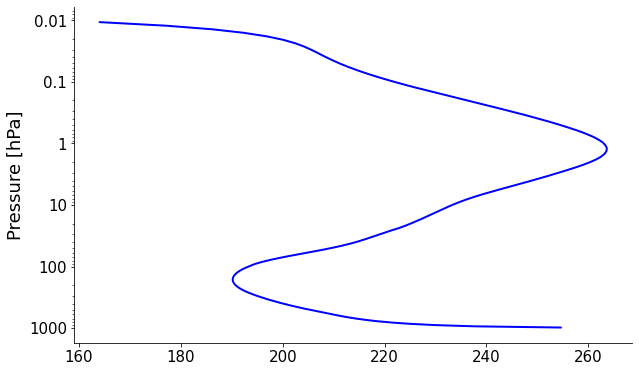

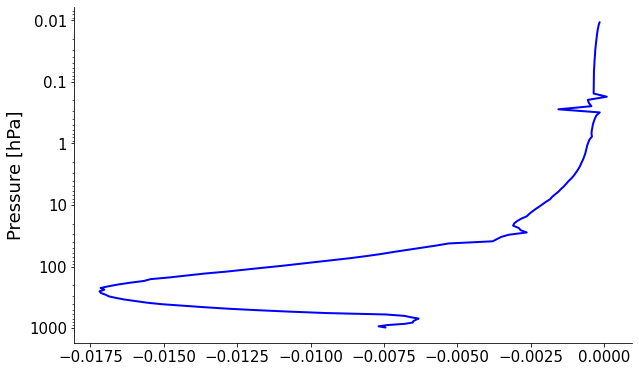

In [5]:
plev, phlev = konrad.utils.get_pressure_grids(1000e2, 1, 128)
atmosphere = konrad.atmosphere.Atmosphere(phlev)
clearsky = konrad.cloud.ClearSky.from_atmosphere(atmosphere)
surface = konrad.surface.SlabOcean(
    temperature=288,
    heat_sink=66,
    )
radiation = konrad.radiation.RRTMG()

RH = manabe_rh(0.77,atmosphere['plev'])


fig, ax = plt.subplots()
plots.profile_p_log(atmosphere['plev'], 
                        atmosphere['T'][0], color = 'blue')
plt.show()

nsteps = 600
timestep = 0.5 #days

fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].set_yscale('log')
ax[0].yaxis.set_inverted(True)
ax[0].set_title('Temperature radiative equilibrium')
ax[0].set_ylabel('Pressure (hPa)')



ax[1].set_yscale('log')
ax[1].set_title('Heating rates')
ax[1].set_ylabel('Pressure (hPa)')
ax[1].yaxis.set_inverted(True)

ax[0].plot(atmosphere['T'][0], atmosphere['plev']/100,
               alpha = 0.5, color = 'red')

for i in range(nsteps):
    radiation.update_heatingrates(atmosphere = atmosphere,surface = surface,cloud=clearsky)
    atmosphere['T'] += radiation['net_htngrt'] * timestep
    net_rad_surface = (radiation['lw_flxd'][0,0] + radiation['sw_flxd'][0,0] - 
                    (radiation['lw_flxu'][0,0] + radiation['sw_flxu'][0,0]))
    surface['temperature'] += (net_rad_surface - surface.heat_sink) * 60*60*24 * timestep / surface.heat_capacity
    atmosphere['H2O'][0] = rh_to_vmr(RH,atmosphere['T'][0],atmosphere['plev'])
    
    alpha = 0.1+0.8*(i/nsteps)**4
    ax[0].plot(atmosphere['T'][0], atmosphere['plev']/100,
               alpha = alpha, color = 'blue')

    
    ax[1].plot(radiation['net_htngrt'][0], atmosphere['plev']/100,
               alpha = alpha, color = 'blue')


plt.show()

print(surface['temperature'])
fig, ax = plt.subplots()
plots.profile_p_log(atmosphere['plev'], 
                        atmosphere['T'][0], color = 'blue')
plt.show()

fig, ax = plt.subplots()
plots.profile_p_log(atmosphere['plev'], 
                        radiation['net_htngrt'][0], color = 'blue')
plt.show()

[288.30652702]
[287.97371255]


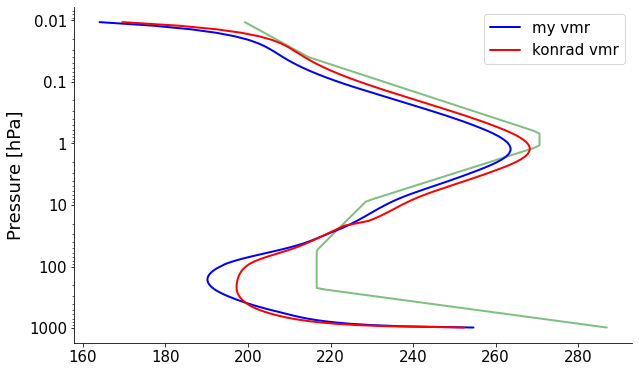

In [6]:
plev, phlev = konrad.utils.get_pressure_grids(1000e2, 1, 128)
atmosphere1 = konrad.atmosphere.Atmosphere(phlev)
clearsky = konrad.cloud.ClearSky.from_atmosphere(atmosphere1)
surface1 = konrad.surface.SlabOcean(
    temperature=288,
    heat_sink=66,
    )
radiation1 = konrad.radiation.RRTMG()

atmosphere2 = konrad.atmosphere.Atmosphere(phlev)
surface2 = konrad.surface.SlabOcean(
    temperature=288,
    heat_sink=66,
    )
radiation2 = konrad.radiation.RRTMG()

RH = manabe_rh(0.77,atmosphere['plev'])


fig, ax = plt.subplots()
plots.profile_p_log(atmosphere1['plev'], 
                        atmosphere1['T'][0], alpha=0.5, color = 'green')

nsteps = 600
timestep = 0.5 #days


for i in range(nsteps):
    radiation1.update_heatingrates(atmosphere = atmosphere1,surface = surface1,cloud=clearsky)
    atmosphere1['T'] += radiation1['net_htngrt'] * timestep
    net_rad_surface1 = (radiation1['lw_flxd'][0,0] + radiation1['sw_flxd'][0,0] - 
                    (radiation1['lw_flxu'][0,0] + radiation1['sw_flxu'][0,0]))
    surface1['temperature'] += (net_rad_surface1 - surface1.heat_sink) * 60*60*24 * timestep / surface1.heat_capacity
    atmosphere1['H2O'][0] = rh_to_vmr(RH,atmosphere1['T'][0],atmosphere1['plev'])
    
    radiation2.update_heatingrates(atmosphere = atmosphere2,surface = surface2,cloud=clearsky)
    atmosphere2['T'] += radiation2['net_htngrt'] * timestep
    net_rad_surface2 = (radiation2['lw_flxd'][0,0] + radiation2['sw_flxd'][0,0] - 
                    (radiation2['lw_flxu'][0,0] + radiation2['sw_flxu'][0,0]))
    surface2['temperature'] += (net_rad_surface2 - surface2.heat_sink) * 60*60*24 * timestep / surface2.heat_capacity
    atmosphere2['H2O'][0] = np.maximum(5e-9,konrad.physics.relative_humidity2vmr(RH,atmosphere2['plev'],atmosphere2['T'][0]))
    
    


print(surface1['temperature'])
print(surface2['temperature'])

plots.profile_p_log(atmosphere1['plev'], 
                        atmosphere1['T'][0], color = 'blue', label = 'my vmr')
plots.profile_p_log(atmosphere1['plev'], 
                        atmosphere2['T'][0], color = 'red', label = 'konrad vmr')
plt.legend()
plt.show()


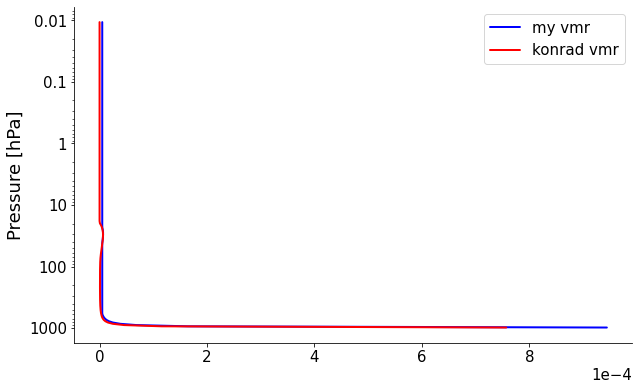

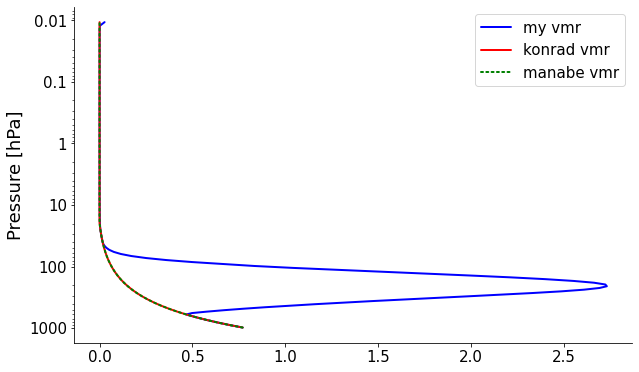

In [11]:
fig, ax = plt.subplots()
plots.profile_p_log(atmosphere1['plev'], 
                        atmosphere1['H2O'][0], color = 'blue', label = 'my vmr')
plots.profile_p_log(atmosphere1['plev'], 
                        atmosphere2['H2O'][0], color = 'red', label = 'konrad vmr')
plt.legend()
plt.show()

fig, ax = plt.subplots()
plots.profile_p_log(atmosphere1['plev'], 
                        vmr_to_rh(atmosphere1['H2O'][0],atmosphere1['T'][0],atmosphere1['plev']),
                    color = 'blue', label = 'my vmr')
plots.profile_p_log(atmosphere1['plev'], 
                        vmr_to_rh(atmosphere2['H2O'][0],atmosphere2['T'][0],atmosphere2['plev']), 
                    color = 'red', label = 'konrad vmr')
plots.profile_p_log(atmosphere1['plev'], 
                        RH, 
                    color = 'green', label = 'manabe vmr', linestyle = 'dotted')
plt.legend()
plt.show()